# NOTE

## Con Outlier
Ridge (alpha=1.0):
- [Linear OLS] RMSE: 0.6814 | R2: 0.6457
- [Ridge Regr.] RMSE: 0.6877 | R2: 0.6391
- Miglioramento Ridge su OLS: -0.92% (Se positivo, Ridge ha ridotto l'errore)

Lasso (alpha=0.02):
- [Linear OLS] RMSE: 0.6814 | R2: 0.6457
- [Ridge Regr.] RMSE: 0.7541 | R2: 0.5660
- Miglioramento Ridge su OLS: -10.68%

ElasticNet:
- MSE: 0.5446244274183548
- R2: 0.5843859158005299

Nuova feature (Ridge) (alpha=0.02):
- MSE: 0.5329710148208457
- R2: 0.593278874251679

Nuova feature (Lasso) (alpha=0.02):
- MSE: 0.5403798422696692
- R2: 0.5876250458882859

## Senza Outlier: 0.70 / 0.30
Ridge (alpha=1.0):
- [Linear OLS] RMSE: 0.4766 | R2: 0.6742
- [Ridge Regr.] RMSE: 0.4852 | R2: 0.6623
- Miglioramento Ridge su OLS: -1.81% (Se positivo, Ridge ha ridotto l'errore)

## Senza Outlier: 0.75 / 0.25
Ridge (alpha=1.0):
- [Linear OLS] RMSE: 0.5195 | R2: 0.6912
- [Ridge Regr.] RMSE: 0.5253 | R2: 0.6843
- Miglioramento Ridge su OLS: -1.12% (Se positivo, Ridge ha ridotto l'errore)

# IMPORT LIBRERIE

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Strumenti Scikit-Learn (Solo quelli studiati finora)
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import ElasticNet

# Configurazione grafica
plt.style.use('seaborn-v0_8-whitegrid')

# CARICAMENTO DATASET e SPLIT INIZIALE

In [62]:
print("--- 1. Caricamento Dati ---")
data = pd.read_csv("california_housing_data.csv")
data.head()

--- 1. Caricamento Dati ---


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [63]:
# Info dataset
data.info()

# Statistiche descrittive
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Ho tutti numeri (niente stringhe) non nulli -> niente pulizia

## Outlier

In [64]:
# Calcolo Q1 e Q3
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Mantengo solo i dati senza outlier
data_clean = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

## Separazione variabili

In [65]:
X = data_clean.drop("MedHouseVal", axis=1)
y = data_clean["MedHouseVal"]

# SPLIT PRIMA DI TUTTO! 
# Regola d'oro: Non guardare mai il Test Set durante il preprocessing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train Set: {X_train.shape}")
print(f"Test Set:  {X_test.shape}")

Train Set: (13049, 8)
Test Set:  (3263, 8)


# FEATURE ENGINEERNG (Polinomi)

In [66]:
# Vogliamo catturare curve, non solo rette. Usiamo il grado 2.
# Nota: include_bias=False perché l'intercetta la calcola già il modello dopo.
print("\n--- 2. Espansione Polinomiale ---")
poly = PolynomialFeatures(degree=2, include_bias=False)

# FIT solo su TRAIN
X_train_poly = poly.fit_transform(X_train)

# TRANSFORM su TEST (Usiamo le regole imparate dal Train)
X_test_poly = poly.transform(X_test)

print(f"Nuove dimensioni Train (Feature esplose): {X_train_poly.shape}")
# Da 8 feature siamo passati a 44 (quadrati e interazioni tra tutte le colonne)


--- 2. Espansione Polinomiale ---
Nuove dimensioni Train (Feature esplose): (13049, 44)


# SCALING (Standardizzazione)

In [67]:
# Fondamentale per Ridge: se abbiamo x e x^2, x^2 sarà enorme. Dobbiamo scalarli.
print("\n--- 3. Standardizzazione (Z-Score) ---")
scaler = StandardScaler()

# FIT solo su TRAIN (Calcola media e deviazione standard del train)
X_train_scaled = scaler.fit_transform(X_train_poly)

# TRANSFORM su TEST (Usa media e dev. std. del TRAIN per scalare il test)
# Se facessimo fit sul test, sarebbe Data Leakage!
X_test_scaled = scaler.transform(X_test_poly)


--- 3. Standardizzazione (Z-Score) ---


# MODELLAZIONE (Confronto Lineare vs Ridge)

In [68]:
print("\n--- 4. Addestramento Modelli ---")

# --- Modello A: Regressione Lineare Semplice (Sui dati polinomiali) ---
# Rischio: Overfitting perché abbiamo 44 feature complesse e nessuna penalità.
model_linear = LinearRegression()
model_linear.fit(X_train_scaled, y_train)
y_pred_linear = model_linear.predict(X_test_scaled)

# --- Modello B: Ridge Regression (Regolarizzato) ---
# Soluzione: Penalizziamo i pesi troppo alti. 
# Alpha = 1.0 è un valore standard di partenza.
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train_scaled, y_train)
y_pred_ridge = model_ridge.predict(X_test_scaled)


--- 4. Addestramento Modelli ---


# VALUTAZIONE E CONFRONTO

In [69]:
print("\n--- 5. Risultati sul Test Set ---")

# Metriche Modello Lineare (Senza freno)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2_lin = r2_score(y_test, y_pred_linear)
print(f"[Linear OLS] RMSE: {rmse_lin:.4f} | R2: {r2_lin:.4f}")

# Metriche Modello Ridge (Con freno)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"[Ridge Regr.] RMSE: {rmse_ridge:.4f} | R2: {r2_ridge:.4f}")

# Calcoliamo il miglioramento
improvement = (rmse_lin - rmse_ridge) / rmse_lin * 100
print(f"Miglioramento Ridge su OLS: {improvement:.2f}% (Se positivo, Ridge ha ridotto l'errore)")


--- 5. Risultati sul Test Set ---
[Linear OLS] RMSE: 0.5195 | R2: 0.6912
[Ridge Regr.] RMSE: 0.5253 | R2: 0.6843
Miglioramento Ridge su OLS: -1.12% (Se positivo, Ridge ha ridotto l'errore)


# DIAGNOSTICA VISIVA (Usiamo il modello Ridge vincente)

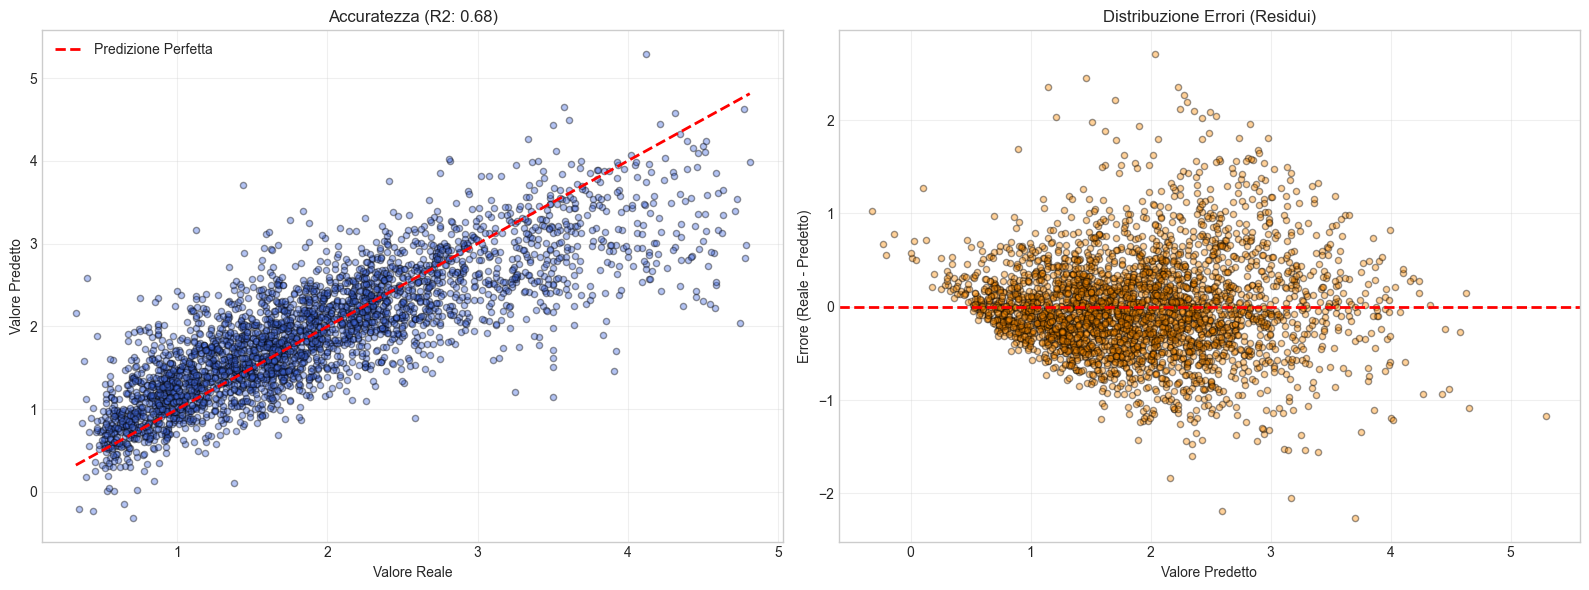


--- Analisi Pesi (Top 5 Feature più influenti) ---
               Feature      Peso  Abs_Peso
15    MedInc Longitude -2.580924  2.580924
22  HouseAge Longitude -2.024549  2.024549
42  Latitude Longitude  1.549182  1.549182
21   HouseAge Latitude -1.458142  1.458142
14     MedInc Latitude -1.414822  1.414822


In [70]:
residuals = y_test - y_pred_ridge

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Grafico 1: Reale vs Predetto
axs[0].scatter(y_test, y_pred_ridge, alpha=0.4, color='royalblue', edgecolor='k', s=20)
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Predizione Perfetta')
axs[0].set_title(f'Accuratezza (R2: {r2_ridge:.2f})')
axs[0].set_xlabel('Valore Reale')
axs[0].set_ylabel('Valore Predetto')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Grafico 2: Residui
axs[1].scatter(y_pred_ridge, residuals, alpha=0.4, color='darkorange', edgecolor='k', s=20)
axs[1].axhline(0, color='red', linestyle='--', lw=2)
axs[1].set_title('Distribuzione Errori (Residui)')
axs[1].set_xlabel('Valore Predetto')
axs[1].set_ylabel('Errore (Reale - Predetto)')
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analisi dei Coefficienti per vedere cosa ha imparato Ridge
print("\n--- Analisi Pesi (Top 5 Feature più influenti) ---")
feature_names = poly.get_feature_names_out(X.columns)
coefs = pd.DataFrame({
    'Feature': feature_names,
    'Peso': model_ridge.coef_
})
# Ordiniamo per valore assoluto del peso (importanza)
coefs['Abs_Peso'] = coefs['Peso'].abs()
print(coefs.sort_values(by='Abs_Peso', ascending=False).head(5))

# ElasticNet

In [71]:
model_elastic = ElasticNet(alpha=0.02, l1_ratio=0.5)

model_elastic.fit(X_train, y_train)
y_pred = model_elastic.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R2:", r2)

MSE: 0.3217892940433569
R2: 0.6318709354755532


# Creazione della nuova feature

In [72]:
# Creazione della nuova feature
data['BedroomsRatio'] = data['AveBedrms'] / (data['AveRooms'] + 1e-6)

# Selezione delle feature X (aggiungi BedroomsRatio)
X = data[['MedInc', 'AveRooms', 'AveBedrms', 'HouseAge', 'Latitude','Longitude', 'BedroomsRatio']]
y = data['MedHouseVal']

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Alleniamo un modello Lasso
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=0.02)
model_lasso.fit(X_train_scaled, y_train)

# Predizioni e metriche
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model_lasso.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R2:", r2)

MSE: 0.5403798422696692
R2: 0.5876250458882859
